# MECHANICAL TURK

## Setup

```bash
pip install -r requirements.txt
```


In [1]:
import os

os.environ.setdefault("TF_ENABLE_ONEDNN_OPTS", "0")
os.environ.setdefault("KERAS_BACKEND", "tensorflow")
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "3")

import cv2
import pickle
import os, glob
import numpy as np

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

import itertools
import shutil

from PIL import Image
from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
from matplotlib import pyplot as plt

import requests

MODEL_FILENAME = "model.keras"
MODEL_LABELS_FILENAME = "model_labels.dat"
TRAIN_DATASET_DIR = "datasets/train"
TEST_DATASET_DIR = "datasets/test"
BASE_URL = "https://ac185e5fdb155d78.247ctf.com"

## Generating training dataset

Using the NotoSans-Regular.ttf font, which is close to the original CAPTCHA image, generate multiple images with different rotations.
The generated images is saved to the format datasets/train/\<label>/\<num>.png.


In [2]:
def generate_and_save_char_image(char, rotation, output_path):
    image_size = (50, 50)
    font_size = 20
    background_color = 255
    font_path = "NotoSans-Regular.ttf"

    image = Image.new("L", image_size, background_color)
    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype(font_path, font_size)

    draw.text((25, 25), char, font=font, fill=50)

    image = image.rotate(rotation, fillcolor=255)

    # Pillow -> OpenCV for OpenCV threshold and contours
    image = np.array(image, dtype=np.uint8)

    _, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    assert len(contours) == 1, f"Expected is 1, but actual is {len(contours)}"
    x, y, w, h = cv2.boundingRect(contours[0])
    image = image[y : y + h, x : x + w]

    image = cv2.resize(image, (20, 20))
    cv2.imwrite(output_path, image)


# initialize
shutil.rmtree(TRAIN_DATASET_DIR, ignore_errors=True)

for c, r in itertools.product("0123456789+", range(-15, 15)):
    os.makedirs(os.path.join(TRAIN_DATASET_DIR, c), exist_ok=True)
    output = os.path.join(TRAIN_DATASET_DIR, c, f"r{r}.png")
    generate_and_save_char_image(c, r, output)

## Training

### Load Image


In [3]:
data, labels = [], []

for image_file in glob.glob(f"{TRAIN_DATASET_DIR}/**/*.png"):
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, image = cv2.threshold(image, 140, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    image = np.expand_dims(image, axis=2)

    label = image_file.split(os.path.sep)[-2]

    data.append(image)
    labels.append(label)

### Create dataset


In [4]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

(X_train, X_test, Y_train, Y_test) = train_test_split(
    data, labels, test_size=0.25, random_state=0
)

lb = LabelBinarizer().fit(Y_train)
Y_train = lb.transform(Y_train)
Y_test = lb.transform(Y_test)

with open(MODEL_LABELS_FILENAME, "wb") as f:
    pickle.dump(lb, f)

### Create model, fit and save


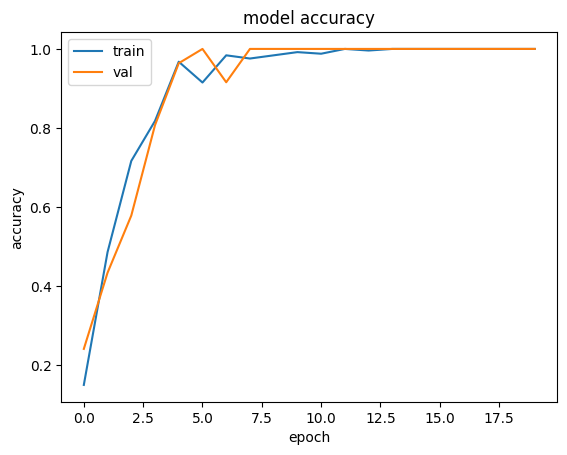

In [5]:
model = Sequential(
    [
        Conv2D(20, (5, 5), padding="same", input_shape=(20, 20, 1), activation="relu"),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(50, (5, 5), padding="same", activation="relu"),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Flatten(),
        Dense(500, activation="relu"),
        Dense(len(lb.classes_), activation="softmax"),
    ]
)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(
    X_train,
    Y_train,
    validation_data=(X_test, Y_test),
    batch_size=128,
    epochs=20,
    verbose=0,
)

# https://stackoverflow.com/a/56807595/10819876
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

model.save(MODEL_FILENAME)

## Test

### Download MTURK CAPTCHA image for test dataset


In [6]:
for i in range(1, 101):
    os.makedirs(TEST_DATASET_DIR, exist_ok=True)
    output = os.path.join(TEST_DATASET_DIR, f"{i:03}.png")

    if os.path.exists(output):
        # print(f"skip download for {output}")
        continue

    res = requests.get(f"{BASE_URL}/mturk.php", allow_redirects=False)
    assert res.status_code == 200, f"Expected is 200, but actual is f{res.status_code}"

    with open(output, "wb") as f:
        f.write(res.content)

### Test


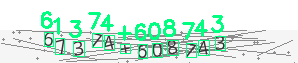

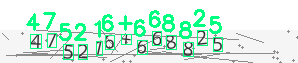

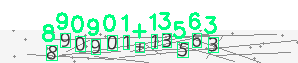

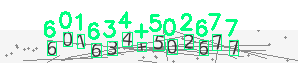

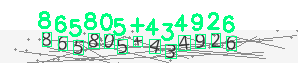

In [7]:
with open(MODEL_LABELS_FILENAME, "rb") as f:
    lb = pickle.load(f)

model = load_model(MODEL_FILENAME)


def predict(org_image, bounding_boxes):
    predictions = []
    for bounding_box in bounding_boxes:
        x, y, w, h = bounding_box

        image = org_image[y : y + h, x : x + w]
        image = cv2.resize(image, (20, 20))
        image = np.expand_dims(image, axis=2)
        image = np.expand_dims(image, axis=0)

        prediction = model.predict_on_batch(image)

        letter = lb.inverse_transform(prediction)[0]
        predictions.append(letter)

    return predictions


def process_image(image_file):
    org_image = cv2.imread(image_file)
    image = org_image.copy()

    # erase background points and lines
    image[np.all(image == (140, 140, 140), axis=-1)] = (255, 255, 255)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, image = cv2.threshold(image, 140, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # display(Image.fromarray(image))

    _, thresh = cv2.threshold(image, 140, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # sort by x
    bounding_boxes = [cv2.boundingRect(c) for c in contours]
    (contours, bounding_boxes) = zip(
        *sorted(zip(contours, bounding_boxes), key=lambda b: b[1][0])
    )

    return org_image, image, bounding_boxes


test_dataset_files = list(glob.glob(os.path.join(TEST_DATASET_DIR, "*.png")))
test_dataset_files = np.random.choice(test_dataset_files, size=(5,), replace=False)

for image_file in test_dataset_files:
    org_image, image, bounding_boxes = process_image(image_file)

    predictions = predict(image, bounding_boxes)

    # plot with predict
    output = cv2.copyMakeBorder(
        org_image, 30, 0, 0, 0, cv2.BORDER_CONSTANT, value=(255, 255, 255)
    )

    for prediction, bounding_box in zip(predictions, bounding_boxes):
        x, y, w, h = bounding_box

        cv2.rectangle(output, (x, y + 30), (x + w, y + h + 30), (0, 255, 128), 1)
        cv2.putText(
            output,
            prediction,
            (x - 5, y - 5 + 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            (0, 255, 128),
            2,
        )

    display(Image.fromarray(output))